In [0]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [0]:
from fastai import *
from fastai.text import *
from fastai.vision import *

#Preparing the data


In [51]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [52]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [53]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per revie , with a lable('positive' or 'negative'), the text and a flag to determine if it should be part of the validation set or training set. If we ignoe this flag, we can create a DataBunch containing this data in one line of code.

In [0]:
data_lm = TextDataBunch.from_csv(path,'texts.csv')

By executing this line a process was launched that took a bit of time.Let's dig a bit into it. Images could be fed(almost) directly into a model beacause they're justa  big array of pixel values that are floats between 0  and 1. A text is composed of words, we can't apply matheamtical functions to them directly. We first have to convert them to numbers. This is done in two different steps:tokenization and numercalization. A textDataBunch does all of that behind the secens for you.

Before we delve into the explaination,let's take to save things that were calculated.

In [0]:
data_lm.save()

Next time w elauch the notebook we skip all tye abov eliness and we can directly use this to save time

In [0]:
data = load_data(path)

#Tokenization
The first step od processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be split the string on spaces, but we can be smarter:
 1. We need to take care of punctuations
 2.Some words are contaractions of two different words, like isn't and don't
 3.We may need to clean some parts of our texts, if there's HTML code for instance
 
 
 
 To see what tokens had done the scenes, let's have a look texts in a batch.


In [57]:
data = load_data(path)
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


The text are trucated at 100 tokens for more readility. We can see that it diid ore that just split on space and punctuation symbols:

1.the "s" are grouped together in one token

2.the contractions are separated like his:  "did" , "n't"

3.content has been cleaned for any HTML symbol and lower cased

4.there are several special tokens(all those that begin by xx), to replace unknown tokens(see below) or to introduce different text fields(here we only have one) 


#Numericalization

Once we have extrated tokens from our texts, we can convert to integers by creating a list of all words used. We only keep the onces that appear at list twice with the maximum vocabulary size of 60,000(by default) and replace the ones that don't make the cut by th unknown token **UNK** 

The correspondance from ids tokens is stored in the **vocab** attribute of our datset, in a dictionary called itos(for int to string)

In [58]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datsste, we'll see the tokenized text as representation.

In [59]:
data.train_ds[0][0] 

Text xxbos xxmaj all i can say is , first movie this season that got my attention . i picked it because of the actors , xxmaj xxunk and xxmaj claire , and the story looked promising .. i have just watched it and i can say - i 'm xxunk . xxmaj there are shocking scenes , true .. but that 's what makes it more realistic . xxmaj we should n't run away from our reality , these things are happening right this moment . xxmaj and there are experts who are trying to change things and make things better and who get laughed out about their commitment to the cause . xxmaj actually i ca n't seem to feel the " xxmaj hollywood touch " in the movie .. and that 's what makes it better . xxmaj both xxmaj claire and xxmaj richard did a great roles , and deserve a 10 from me .

But underlying data is all numbers.

In [60]:
data.train_ds[0][0].data[:10]

array([  2,   5,  46,  19,  86, 150,  16,  10, 103,  30])

In [61]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/models')]

In [62]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos')]

#Language Model

We're not going to train a model that classidies the reviews fro scratch. Like in the comuetr vison we'll use a pretarined on a bigger dataset(a cleaned subset of wikipedia called wikitext-103).That model has been tarined to guess what the next word,its input being all the previous words.It has a recurrent structure and a hidden state that is updated each time it sees a new word.This is hidden state thus contains information about the sentence up to that point.

We are going to us that 'Knowledge' of English language to built our classifier,but first, like for computer vision, we need t fine-tune the pretarined model to our particular datset. Beacause the ENglish of the reviex lefts by the people on IMDB isnt the same as the English of wikipediua, we'll need to adjust a little the parameters  of our model. Plus there ight be soem words extreemly common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where unlablled data is going to useful to us, as we use it to fine tune our model.Let's create our data object with the data block API(next line takes a few minutes)


In [0]:
data_lm = (TextList.from_folder(path)
           #Input all tyhe text files in the path
           .filter_by_folder(include=['train','test'])
           #We may have another temp folder that contains textfiles so we only keep what's in train and test
           .split_by_rand_pct(0.1)
           #We randomly split andkeep 10% (10,000 review) for validation
           .label_for_lm()
           #We want todo a language odel so we label accordingly
           .databunch())
data_lm.save('/tmp_lm')

In [64]:
data_lm.show_batch()

idx,text
0,"better than number 5 . xxmaj my expectations were n't high to begin with , but this is cheap direct - to - video stuff , not even a horror movie , it 's xxup pg-13 . xxmaj the acting was not convincing , the story was rather dumb without any excitement and there were not many effects . xxmaj but the main problem is that there were no kills"
1,"can conveniently reveal herself as a top negotiator and diplomat , because she is so superior , ya know . xxmaj to top it out , she is played by a wooden actress . \n \n xxmaj the more talented xxmaj boreanaz serves as a faire - xxunk token for this construct , acting as a bumbling comic - relief and house "" xxmaj watson "" . xxmaj in"
2,"person . xxmaj if you have a friend who laughs at everything , i encourage you to watch this movie with him or her , and watch as even they wo n't get a chuckle out of this film . xxmaj if you 're an insomniac this movie is sure to put you to sleep . xxmaj do not operate heavy machinery while watching xxmaj plan a part xxup ii"
3,"the description the cable had , atleast . xxmaj this film was awful . xxmaj it 's slow , the pacing is horrible , it feels as tho it lasts 4 hours . xxmaj there 's no real plot to speak of ... xxunk ! xxmaj how can anyone say anything good about this movie . xxmaj rickman is good ... but he always is ... the other two characters"
4,"guy that acted so much better with xxmaj keanu xxmaj reeves in xxmaj point xxmaj break play in this disaster . xxmaj it was a feel - good movie , but there are thousands of other feel - good movies that make you laugh without wanting you to get your money back . \n \n xxmaj the only reason i would ever tell someone to rent this movie is"


We can then put the learner object very easily with a model loaded with the pretarined weights.They'll be downloaded the first time you'll execute the following line and stored in'/fastai/models/'(or elsewhere if you specified diffrent paths in your config file)'

In [0]:
learn = language_model_learner(data_lm,  AWD_LSTM, drop_mult=0.3)

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


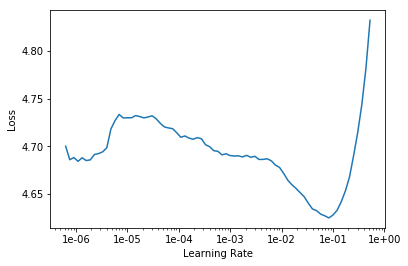

In [67]:
learn.recorder.plot(skip_end=15)

In [68]:
learn.fit_one_cycle(1,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.101762,3.963885,0.297464,19:09


In [0]:
 learn.save('fit-head')

In [70]:
learn.load('fit-head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos i absolutely love the first three movies , they were great ! i once caught xxmaj part 5 on xxup vhs 10 years ago , and i was disappointed . xxmaj but perhaps that was because i never saw the fourth one , because they were shot back - to - back . but after finally viewing a copy today , i have to say it was no way better than number 5 . xxmaj my expectations were n't high to begin with , but this is cheap direct - to - video stuff , not even a horror movie , it 's xxup pg-13 . xxmaj the acting was not convincing , the story was rather dumb without any excitement and there were not many effects . xxmaj but the main problem is that there were no kills or any gore ( the annoying kid who gets killed in his car was supposed to be the highlight , but come on .. ) 
 
  xxmaj surprisingly , both xxmaj parts 4 and 5 were directed by xxmaj sequel - director xxmaj jeff xxmaj burr who gave us the excellent xxm

In [71]:
learn.predict('The school is ', 1, temperature=1.1,min_p=0.001)

'The school is  being'

In [0]:
 learn.save('fit-head')

In [73]:
 learn.load('fit-head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos i absolutely love the first three movies , they were great ! i once caught xxmaj part 5 on xxup vhs 10 years ago , and i was disappointed . xxmaj but perhaps that was because i never saw the fourth one , because they were shot back - to - back . but after finally viewing a copy today , i have to say it was no way better than number 5 . xxmaj my expectations were n't high to begin with , but this is cheap direct - to - video stuff , not even a horror movie , it 's xxup pg-13 . xxmaj the acting was not convincing , the story was rather dumb without any excitement and there were not many effects . xxmaj but the main problem is that there were no kills or any gore ( the annoying kid who gets killed in his car was supposed to be the highlight , but come on .. ) 
 
  xxmaj surprisingly , both xxmaj parts 4 and 5 were directed by xxmaj sequel - director xxmaj jeff xxmaj burr who gave us the excellent xxm

In [74]:
learn.unfreeze()
learn.fit_one_cycle(5,1e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.902964,3.928042,0.300791,22:19
1,3.856772,3.896575,0.304122,22:18
2,3.854727,3.881266,0.305676,22:19
3,3.853367,3.875036,0.306408,22:19
4,3.857768,3.874080,0.306530,22:18
